> Yuri Diego Santos Niitsuma

Todo o código, inclusive o **Jupyter Notebook** está disponível em https://github.com/ignitz/datamining_tp2

# Objetivo

O trabalho prático 2 consiste em utilizar técnicas de agrupamentos da segunda parte
do cronograma do curso. A proposta de objetivo do trabalho é agrupar documentos com
características similares, que assim espera-se ter como resultado uma classificação
automática dos documentos.

# Base de dados

A base de dados que será utilizada é a BBC News Articles, a mesma base de
dados do trabalho prático 1 https://www.kaggle.com/pariza/bbc-news-summary/home

Nesta base, consiste em publicações de artigos de notícias divididos em 5
categorias:

- Negócios (business)
- Entretenimento (entertainment)
- Política (politics)
- Esporte (sport)
- Tecnologia (tech)


# Metodologia

Os documentos serão misturados e após o processo de clusterização será verificada
se com alguns parâmetros se aproximará da divisão inicial ou se encontrará uma
característica nova da base de dados.

Em resumo iremos utilizar um classificador não supervisionado e verificaremos a acurácia do modelo comparando com a classe já rotulada.

In [1]:
import gensim
import numpy as np
import collections
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%pylab inline
# Para o PDF exportado conter as imagens vetorizadas
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import os
import pandas as pd

# model.save(fname)
# model = Doc2Vec.load(fname)  # you can continue training with the loaded model!
# model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

c:\users\ignit\local\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Leitura do dataset mantendo o texto original e separando em tokens

bbc_news_folder = 'BBC News Articles'

content = dict()

for article_class in os.listdir(bbc_news_folder):
    collections_articles = []
    for each_article in os.listdir(bbc_news_folder + '/' + article_class):
        article = ''
        with open(bbc_news_folder + '/' + article_class + '/' + each_article) as f:
            article = f.read()
            article_preprocess = gensim.utils.simple_preprocess(article, article_class)
            
        collections_articles.append((article, article_preprocess))
        
    content[article_class] = collections_articles

content.keys()

dict_keys(['business', 'entertainment', 'politics', 'sport', 'tech'])

In [3]:
dfs = []
dfs += [pd.DataFrame({'class': 'business', 'texts': [x for x, y in content['business']], 'tokens': [y for x, y in content['business']]})]
dfs += [pd.DataFrame({'class': 'entertainment', 'texts': [x for x, y in content['entertainment']], 'tokens': [y for x, y in content['entertainment']]})]
dfs += [pd.DataFrame({'class': 'politics', 'texts': [x for x, y in content['politics']], 'tokens': [y for x, y in content['politics']]})]
dfs += [pd.DataFrame({'class': 'sport', 'texts': [x for x, y in content['sport']], 'tokens': [y for x, y in content['sport']]})]
dfs += [pd.DataFrame({'class': 'tech', 'texts': [x for x, y in content['tech']], 'tokens': [y for x, y in content['tech']]})]
df = pd.concat(dfs)
df['class'].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

Como pode ver o texto original com tokens separados.

In [4]:
df.head()

,class,texts,tokens
0,business,Ad sales boost Time Warner profit\n\nQuarterly...,"[ad, sales, boost, time, warner, profit, quart..."
1,business,Dollar gains on Greenspan speech\n\nThe dollar...,"[dollar, gains, on, greenspan, speech, the, do..."
2,business,Yukos unit buyer faces loan claim\n\nThe owner...,"[yukos, unit, buyer, faces, loan, claim, the, ..."
3,business,High fuel prices hit BA's profits\n\nBritish A...,"[high, fuel, prices, hit, ba, profits, british..."
4,business,Pernod takeover talk lifts Domecq\n\nShares in...,"[pernod, takeover, talk, lifts, domecq, shares..."


In [5]:
# Contagem do total de documentos
df.drop(['texts', 'tokens'], axis=1).describe()

,class
count,2225
unique,5
top,sport
freq,511


In [6]:
# Contagem dos documentos de cada classe
df.groupby('class').count()

,texts,tokens
class,,
business,510,510
entertainment,386,386
politics,417,417
sport,511,511
tech,401,401


Aqui vamos converter no formato apropriado para o **Doc2Vec** do **gensim** e atrelando um identificador inteiro ao documento.

In [7]:
common_texts = df.drop('class', axis=1).values[:,:].tolist()
documents = [TaggedDocument(doc[1], [i]) for i, doc in enumerate(common_texts)]

# Segue um exemplo
documents[:1], len(documents)

([TaggedDocument(words=['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'at', 'us', 'media', 'giant', 'timewarner', 'jumped', 'to', 'bn', 'for', 'the', 'three', 'months', 'to', 'december', 'from', 'year', 'earlier', 'the', 'firm', 'which', 'is', 'now', 'one', 'of', 'the', 'biggest', 'investors', 'in', 'google', 'benefited', 'from', 'sales', 'of', 'high', 'speed', 'internet', 'connections', 'and', 'higher', 'advert', 'sales', 'timewarner', 'said', 'fourth', 'quarter', 'sales', 'rose', 'to', 'bn', 'from', 'bn', 'its', 'profits', 'were', 'buoyed', 'by', 'one', 'off', 'gains', 'which', 'offset', 'profit', 'dip', 'at', 'warner', 'bros', 'and', 'less', 'users', 'for', 'aol', 'time', 'warner', 'said', 'on', 'friday', 'that', 'it', 'now', 'owns', 'of', 'search', 'engine', 'google', 'but', 'its', 'own', 'internet', 'business', 'aol', 'had', 'has', 'mixed', 'fortunes', 'it', 'lost', 'subscribers', 'in', 'the', 'fourth', 'quarter', 'profits', 'were', 'lower', 'than', '

## Treinamento do Word2Vec/Doc2Vec

Aqui ocorre o treinamento, que é feito o dicionário, o treinamento Word2vec junto com umvetor de parágrafo a cada documento (o que origina o Doc2Vec).

O vetor criado será de 50 dimensões.

In [8]:
model = Doc2Vec(documents, vector_size=50, window=5, min_count=1, epochs=30, workers=4)

## Visualização do Word2vec

O Word2Vec também é treinado, por isso vamos verificar como as caracteríscas das palavras foram separadas

Vamos aplicar **Principal Component Analysis** (PCA) nos dados para termos uma melhor visualização em 2D.

In [9]:
pd_pca = pd.DataFrame(model.wv.vectors)
pd_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.375355,-0.381651,0.061568,0.283360,0.354209,0.586557,-1.067924,0.724377,0.640920,-0.498582,...,-0.008950,-0.197127,0.305386,0.264784,-0.132019,-1.227701,-0.013277,0.901681,0.506019,-0.847297
1,-0.803423,1.609968,-1.130389,1.392392,1.379773,-0.976821,1.038727,0.485969,-0.925469,-0.938614,...,-0.542451,-1.773462,-0.084647,-0.320082,-0.819188,-0.438254,0.535370,1.418014,0.897354,-0.178086
2,-1.287684,-1.263752,-0.479420,1.038545,0.661900,0.520444,-0.351887,-0.071359,1.129165,-1.412369,...,-0.029634,0.578517,1.332354,-1.095514,-0.712882,-2.049710,-0.048525,-0.557091,-0.050472,-0.191298
3,-0.410766,0.209747,-0.932095,0.435796,0.360755,-0.225246,-0.015753,-0.372011,0.275359,0.654128,...,0.550296,0.104696,0.031105,-1.829921,-0.929289,-0.689938,0.288259,0.609758,-1.477401,-0.322369
4,-0.657729,-0.453806,-0.904033,0.088301,1.243439,0.217684,-0.968123,0.901782,-0.309569,-0.352739,...,-0.356940,0.535343,-0.024968,-0.613644,-0.098649,0.118351,-0.429254,-0.871531,-0.211665,-1.302433


In [10]:
pd_pca.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,...,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000
mean,-0.050268,-0.026485,-0.080721,0.002276,0.125809,0.304845,0.005299,0.216801,-0.025314,0.060193,...,0.240919,-0.145769,-0.086042,-0.083296,0.030044,-0.079417,0.060744,-0.033544,-0.004000,0.055729
std,0.533579,0.520065,0.509098,0.484469,0.516917,0.534108,0.491350,0.502541,0.484094,0.480924,...,0.517603,0.476759,0.481405,0.568239,0.560093,0.532948,0.508675,0.544702,0.499855,0.477218
min,-5.824695,-4.486477,-6.351256,-4.292601,-5.949568,-5.461416,-5.014153,-5.292231,-4.923155,-5.280685,...,-8.340413,-4.409438,-5.409966,-5.473380,-7.188580,-7.097186,-6.156067,-5.874648,-4.260132,-5.759003
25%,-0.191167,-0.162541,-0.191757,-0.144796,-0.049533,0.052565,-0.135087,0.011892,-0.156037,-0.098249,...,0.015172,-0.278971,-0.239173,-0.226531,-0.138878,-0.245122,-0.077673,-0.175581,-0.166917,-0.079116
50%,-0.020958,0.009269,-0.034078,-0.009738,0.090561,0.205375,0.009286,0.168752,-0.016243,0.026341,...,0.156955,-0.109881,-0.088870,-0.061234,0.005805,-0.078575,0.066503,-0.032736,-0.032720,0.053783
75%,0.114491,0.149087,0.098436,0.129349,0.252306,0.439881,0.148798,0.359918,0.117982,0.169613,...,0.373174,0.034309,0.062719,0.099445,0.162664,0.088073,0.212352,0.110499,0.118492,0.188711
max,4.823076,4.902254,3.588440,5.415285,5.316165,5.726840,4.586370,5.516634,4.618442,6.104193,...,5.000909,4.514141,5.135065,5.289593,5.593749,4.394930,5.521087,4.595976,5.056914,4.888290


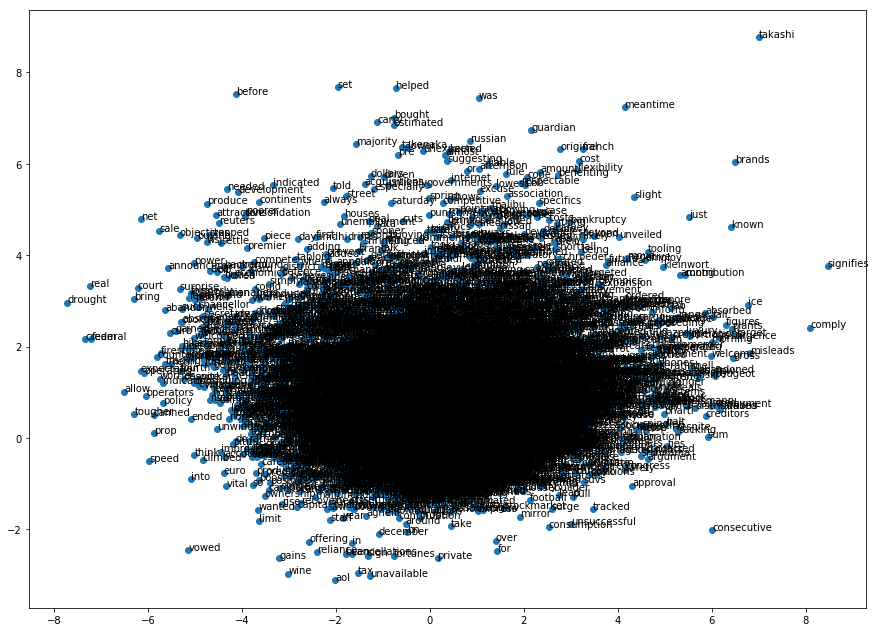

In [14]:
# Isso aqui demora um pouco
plt.figure(figsize=(15,11))
X_pca = PCA(n_components=2).fit_transform(model.wv.vectors)
plt.scatter(X_pca[:, 0], X_pca[:, 1]);

xv = list(zip(X_pca[:, :2].tolist(), model.wv.vocab))

count_left = [0, 0, 0, 0]
for X, word in xv:
    plt.text(X[0], X[1], word)

O PCA em duas dimensões não obtem um bom resultado mas já da para verificar alguns resultados que mostram algumas similaridades entre as palavras

In [11]:
# Segue algumas palavras junto com suas palavras mais similares baseado no treinamento dos dados
for _ in range(5):
    word = np.random.choice(list(model.wv.vocab))
    print(word, model.most_similar(word))
    print()

tone [('urgency', 0.5856815576553345), ('signs', 0.5611457824707031), ('disagreements', 0.5594902634620667), ('sweetener', 0.5466503500938416), ('fact', 0.5440227389335632), ('whiff', 0.5372285842895508), ('tension', 0.5212657451629639), ('apprehension', 0.5203285217285156), ('taxation', 0.5153089165687561), ('brothels', 0.5112128257751465)]

resent [('understanding', 0.5992913842201233), ('riles', 0.5978131294250488), ('thick', 0.570773184299469), ('heightened', 0.5701881051063538), ('displacement', 0.5700898766517639), ('efficacy', 0.54374760389328), ('religion', 0.539901852607727), ('ridiculousness', 0.5276229381561279), ('denunciations', 0.5224276185035706), ('manuscript', 0.521010160446167)]

countryfile [('surveyed', 0.613725483417511), ('posting', 0.5961771011352539), ('benson', 0.5956549048423767), ('transactions', 0.5793359875679016), ('grieving', 0.5681443214416504), ('tensions', 0.5651874542236328), ('liverpudlians', 0.5606149435043335), ('journalists', 0.554060697555542), (

c:\users\ignit\local\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
c:\users\ignit\local\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Doc2Vec

O modelo sendo uma extensão do Word2vec, faz com que cada documento possua um vetor de características também, quer dizer que posso plotar estes dados já certo?

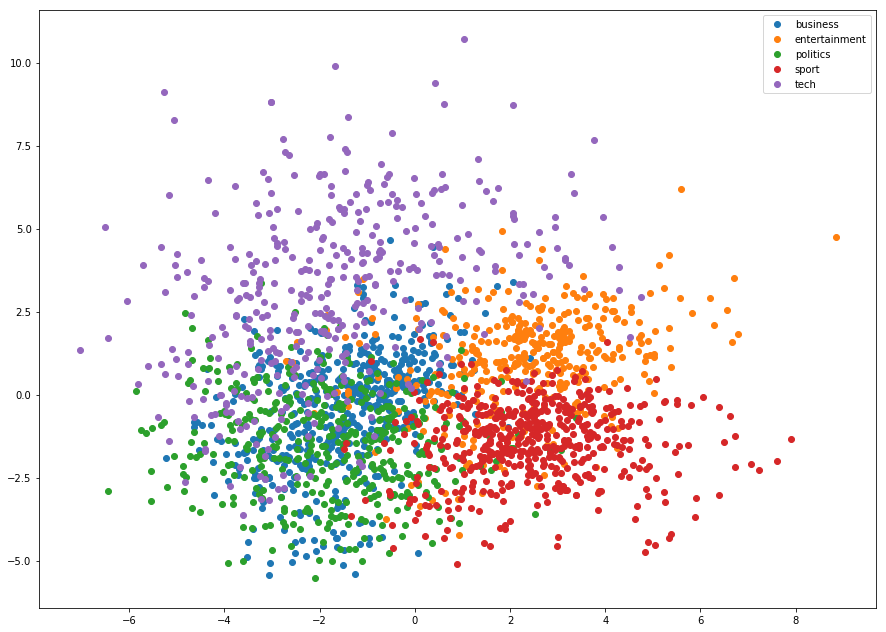

In [12]:
plt.figure(figsize=(15,11))
X_pca = PCA(n_components=2).fit_transform(model.docvecs.vectors_docs)

for cl in df['class'].unique():
    plt.scatter(X_pca[df['class'] == cl, 0], X_pca[df['class'] == cl, 1]);
plt.legend(list(df['class'].unique()));

In [13]:
# Exemplo de inferência utilizando 3 palavras
# o resultado pode ser diferente em cada execução devido ao processo de escolhas aleatórias no método
model.infer_vector(['playstation', 'launchs', 'day'])

array([ 0.03649032, -0.02189194, -0.21670197,  0.10387941, -0.07442366,
        0.38828552,  0.0548493 ,  0.05776116,  0.06041327,  0.05055714,
       -0.07257181, -0.19030558,  0.00718318, -0.05017371, -0.17033762,
        0.22027378,  0.14903647,  0.04072108,  0.01473602,  0.17601186,
        0.10048933,  0.11544574,  0.13109535,  0.10451017,  0.05056227,
       -0.03562302, -0.02262274,  0.21025397, -0.03123427,  0.01517741,
        0.21585454, -0.23880677, -0.07298025, -0.42041168, -0.20753248,
       -0.06107889,  0.09495735, -0.14960605,  0.06073452,  0.06555965,
       -0.04054106, -0.01832818, -0.09735152, -0.07830091, -0.05992536,
        0.07480311,  0.02125435, -0.09300853, -0.2033982 , -0.3173989 ],
      dtype=float32)

Esta função tem como objetivo colecionar os ranks dos documentos além de retornar os vetores dos documentos inferidos.

# Partindo para o lemonade

Vamos utilizar estes dados contendo os vetores inferidos dos documentos para utilizarmos um classificador na plataforma.

In [23]:
columns_name = []
vectors = []
for dim in range(model.vector_size):
    columns_name += ['vec' + str(dim)]
for i in range(model.docvecs.count):
    vectors.append(model.docvecs[i])
vectors = np.array(vectors)

df_vec = pd.DataFrame(vectors, columns=columns_name)
df_vec.head()

,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,vec9,...,vec40,vec41,vec42,vec43,vec44,vec45,vec46,vec47,vec48,vec49
0,0.241990,1.544324,-1.729625,-2.243980,1.111104,3.057871,0.112671,-1.422829,1.014620,1.589811,...,1.045390,-2.112188,-0.991591,-1.148821,-0.283603,-0.843498,1.045136,-1.829892,1.165058,2.293239
1,-0.454185,-0.358959,2.538388,-0.820838,3.074742,0.910791,0.823664,-1.881410,0.433578,0.690477,...,0.441319,-2.185364,-1.967095,-1.234630,1.503886,0.022258,1.385105,1.496157,-1.288961,1.833183
2,-0.105753,1.676019,-0.838937,-1.370789,1.808549,0.125505,-0.746887,-1.537585,-0.117242,-1.093117,...,2.826037,-2.575173,-2.321907,-0.365858,1.574808,-1.164839,2.139742,0.789045,-0.355498,1.613800
3,0.995653,0.789635,-0.162142,-0.986018,2.298610,2.939462,0.313745,-0.416294,0.934520,1.666021,...,1.349079,-1.042372,-1.176036,-1.867611,0.096171,1.527316,1.795872,-1.530347,-1.770471,1.144252
4,0.153031,0.040657,-1.284926,-1.439663,1.451248,0.817655,1.211280,-0.430622,1.333150,1.281701,...,2.726128,-2.330526,-1.927048,-1.382968,0.919577,-1.097198,0.377174,-1.551393,-1.144358,1.504609


In [26]:
# Gravar os vetores para importar no Lemonade
output_data = pd.concat([pd.DataFrame(df['class'].values, columns=['class']), df_vec], axis=1)
output_data.to_csv('BBCNewsdoc2vec.csv', index=False)
output_data.head()

,class,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,...,vec40,vec41,vec42,vec43,vec44,vec45,vec46,vec47,vec48,vec49
0,business,0.241990,1.544324,-1.729625,-2.243980,1.111104,3.057871,0.112671,-1.422829,1.014620,...,1.045390,-2.112188,-0.991591,-1.148821,-0.283603,-0.843498,1.045136,-1.829892,1.165058,2.293239
1,business,-0.454185,-0.358959,2.538388,-0.820838,3.074742,0.910791,0.823664,-1.881410,0.433578,...,0.441319,-2.185364,-1.967095,-1.234630,1.503886,0.022258,1.385105,1.496157,-1.288961,1.833183
2,business,-0.105753,1.676019,-0.838937,-1.370789,1.808549,0.125505,-0.746887,-1.537585,-0.117242,...,2.826037,-2.575173,-2.321907,-0.365858,1.574808,-1.164839,2.139742,0.789045,-0.355498,1.613800
3,business,0.995653,0.789635,-0.162142,-0.986018,2.298610,2.939462,0.313745,-0.416294,0.934520,...,1.349079,-1.042372,-1.176036,-1.867611,0.096171,1.527316,1.795872,-1.530347,-1.770471,1.144252
4,business,0.153031,0.040657,-1.284926,-1.439663,1.451248,0.817655,1.211280,-0.430622,1.333150,...,2.726128,-2.330526,-1.927048,-1.382968,0.919577,-1.097198,0.377174,-1.551393,-1.144358,1.504609


O Job **8116** no lemonade nos da os seguintes resultados:

![Lemonade Gaussian Example](img/JOB8116.PNG)

#### K-Means

Ignore os labels pois tenho que indexar por números as classes.

![K-Means](img/kmeansmatrix.PNG)

O K-means se saiu bem a mais do que o esperado apesar que errou muito. Talvex o conjuntos dos vetores possuem um manifold e distâncias euclidianas não funcionam muito bem para K-means.

#### Gaussian-Mix

![Gaussian-Mix](img/gaussianmatrix.PNG)

O Gaussian mix não consegui fazer funcionar para 50 dimensões, a maldição da dimensionalidade faz com que as distâncias muito longas não influênciam muito para o movimento dos centroides das gaussianas.


# Conclusão

Nesse pequeno dataset perbemos uma boa eficácia do K-Means sobre o Gaussian-Mix neste dados que são bem complicados de transformar em um vetor para agrupá-los. O método do Doc2Vec não se mostrou tão eficaz para o agrupamento pela natureza dos dados apresentados.